In [10]:
import networkx as nx
import csv
import itertools
import matplotlib.pylab as plt

G = nx.Graph()

def cleanData(author):
    author = author.replace(')', '')
    author = author.replace('Inst\.', 'Institute')
    if (author):
        return author

with open('data.csv', 'r') as f:
    reader = csv.reader(f, delimiter=",")
    for row in reader:
        authors = row[3].split("&")
        if (len(authors) == 1):
            G.add_node(authors[0].strip())
        if (len(authors) > 1):
            authors = map(str.strip, authors)
            authors = map(cleanData, authors)
            edges = list(itertools.combinations(authors, 2))
            G.add_edges_from(edges)

nx.write_edgelist(G, 'edgelist.txt')

In [27]:
print nx.info(G)

Name: 
Type: Graph
Number of nodes: 3993
Number of edges: 7856
Average degree:   3.9349


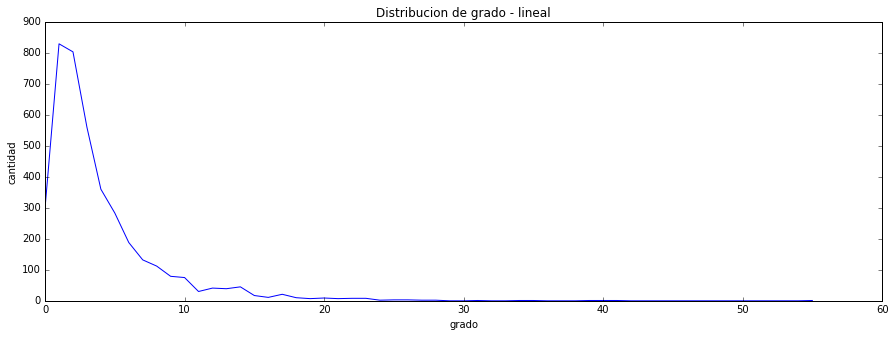

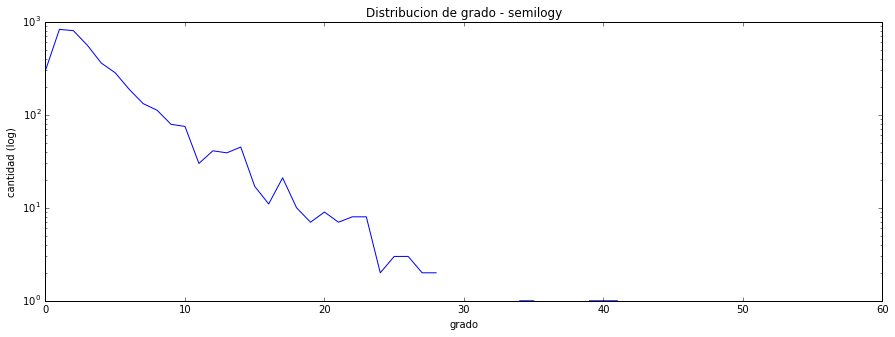

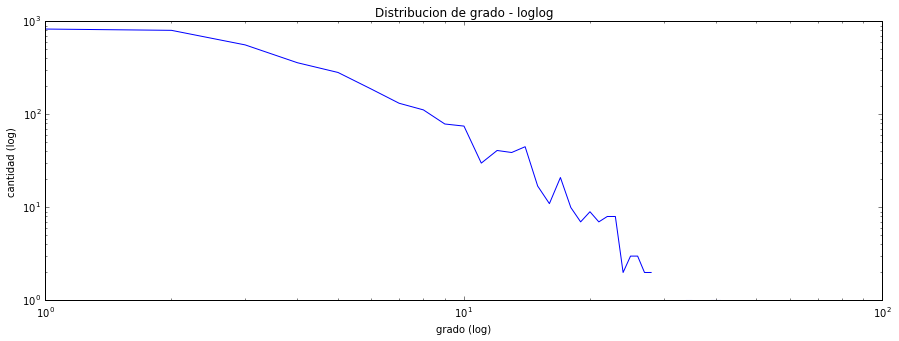

In [37]:
plt.figure(figsize=(15,5))
plt.title("Distribucion de grado - lineal")
plt.plot(nx.degree_histogram(G))
plt.xlabel("grado")
plt.ylabel("cantidad")
plt.show()

plt.figure(figsize=(15,5))
plt.title("Distribucion de grado - semilogy")
plt.semilogy(nx.degree_histogram(G))
plt.xlabel("grado")
plt.ylabel("cantidad (log)")
plt.show()

plt.figure(figsize=(15,5))
plt.title("Distribucion de grado - loglog")
plt.loglog(nx.degree_histogram(G))
plt.xlabel("grado (log)")
plt.ylabel("cantidad (log)")
plt.show()

In [47]:
print "Número de componentes conexas del grafo: %s" % nx.number_connected_components(G)
largest_cc = max(nx.connected_components(G), key=len)
print "Cantidad de nodos de la máxima componente: %s" % len(largest_cc)

Número de componentes conexas del grafo: 536
Cantidad de nodos de la máxima componente: 3013


In [ ]:
def vecindades():
# Elijo un nodo al azar del largest_cc
# Itero sobre sus vecinos, acumulo: cantidad de nodos alcanzados, cantidad de nodos agregados
# en funcion de la distancia al nodo inicial, es decir, en funcion del numero de iteracion
# Hasta completar toda la componente (usar el tamano de la componente previamente calculado)
# Como lidiar con los nodos repetidos?, usar un diccionario para contar solo los nodos nuevos alcanzados

# Graficar los resultados, y reproducirlo varias veces

In [ ]:
# Graficar el grafo, si no se puede completo elegir un porcentaje de los nodos
# que mantengan la distribucion de grado del grafo original